# Set Roulette Metagame Breakdown - July 2021
I've been participating in the Mythic Society's Set Roulette tournaments for a while now, and absolutely love them. The combination of discovery, deckbuilding, nostalgia, collaboration and competition is incredible. The tournaments are highlights of each month. To fill the Set Roulette-shaped void, I've been working on this project during the off-weeks. I've scraped the tournament results and decklists from mtgmelee to do some deck/card/player analysis, and it's great fun to pore over the results. I hope you enjoy as much as I do. - Ryan Kerr

This notebook does the following:
* Clusters decks based on the number of cards they have in common
* Displays the winrate matrix of the largest deck clusters
* Displays the full decklists for each of the deck clusters

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import sys
import inspect
import numpy as np
import pandas as pd
import sqlite3

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from matplotlib import pyplot as plt

from analysis.deck_clustering import DeckClustering

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

DB_PATH = '../mtgmelee.db'

In [3]:
# helper to print out cluster decklists
def display_clusters(df):
    classifications = np.unique(df['classification'])
    for classification in classifications:
        dfc = df[df['classification'] == classification]
        dfc = dfc.loc[:, (dfc != 0).any(axis=0)]
        first_cols = ['classification', 'name', 'title', 'wins', 'losses']
        dfc = dfc.reindex(columns=(first_cols + list([col for col in dfc.columns if col not in first_cols])))
        dfc = dfc.rename(columns={
            'name': 'Player',
            'title': 'Deck Name',
            'classification': 'Cluster',
            'wins': 'Wins',
            'losses': 'Losses',
        })
        display(dfc)

In [4]:
d = DeckClustering(db_path=DB_PATH, tournament_id=7215)

## Heirarchical Deck Clustering
The plot below displays the decklists from July's Set Roulette tournament. Decks that are similar are listed near each other. The X axis represents how similar the decks/clusters are, and you can think of it as "how many cards are different between these two decks". Note that I excluded lands and sideboard cards for this analysis.

The technique used here is called Hierarchical clustering. Decks that are similar are merged together into a cluster, clusters that are similar to each other are merged in to larger clusters, and so on. It's a nice way to visualize the metagame because it identifies clusters of near-identical decks as well as macro-archetypes with a few overlapping cards. I added colors to the visualization to differentiate clusters of decks with 16 or fewer cards in common. The threshold is arbitrary, but it works well enough to distinguish some unique archetypes.

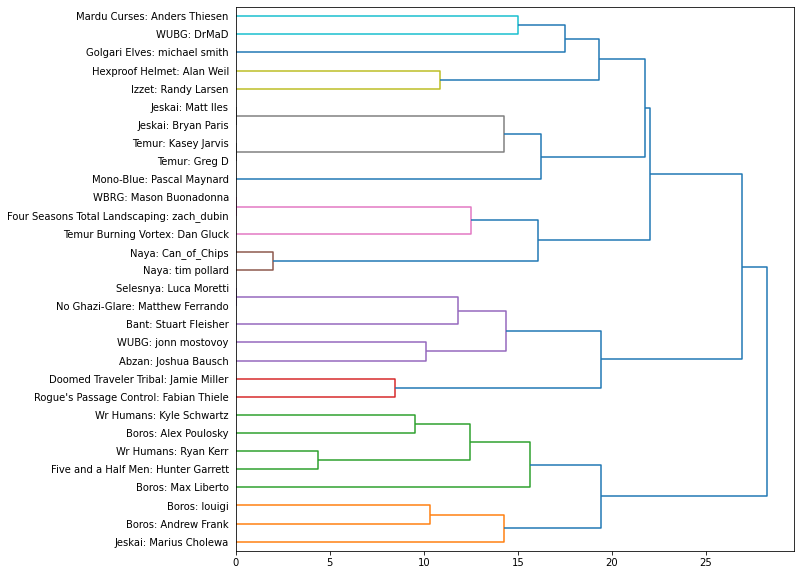

In [5]:
cluster_df, model = d.get_clusters_heirarchical(distance_threshold=16)
plt.figure(figsize=(10, 10))
d.plot_dendrogram(df=cluster_df, model=model, color_threshold=16)

This month's set roulette had a pretty diverse metagame. The largest clusters were Abzan control, Abzan rock/midrange, and Temur/Izzet prowess, but none of those had more than 5 decks. A few other archetypes made an appearance in (G)W aggro, Mardu/Abzan/Azorious Miracles, Orzhov control, and Bant flicker.

## Winrate Matrix
Below is a winrate matrix for the clusters created above. Here's how to read the table: Each row represents a deck cluster, and each cluster has been assigned a number. Decklists that didn't fit into a large cluster are listed as "Other". The first few columns show the winrate and number of matches played between the two decks in that matchup. For example, if a cell says "100%, 2", that means that cluster won 100% of their two matches against the other cluster. To understand what each cluster is, I've listed the most-played cards for decks in that cluster in the last column.

In [6]:
d.get_winrate_matrix(cluster_df, min_cluster_size=3)

,0,2,3,4,5,Other,Num Decks,Non-Mirror %,Non-Mirror Matches,Top Cards
Deck Cluster,,,,,,,,,,
0,"50%, 4","100%, 2","67%, 3","0%, 2","0%, 2","43%, 7",5,44%,16,"Knight of the White Orchid, Lightning Helix, C..."
2,"0%, 2",NaN,"100%, 2","25%, 4",NaN,"33%, 3",3,36%,11,"Figure of Destiny, Lightning Helix, Char"
3,"33%, 3","0%, 2",NaN,"50%, 2","67%, 3","60%, 5",4,47%,15,"Snapcaster Mage, Remand, Fiery Impulse"
4,"100%, 2","75%, 4","50%, 2","50%, 4","50%, 2","47%, 15",5,56%,25,"Birds of Paradise, Hangarback Walker, Garruk R..."
5,"100%, 2",NaN,"33%, 3","50%, 2","50%, 2","25%, 4",3,45%,11,"Mulch, Molten Vortex, Life from the Loam"
Other,"57%, 7","67%, 3","40%, 5","53%, 15","75%, 4","50%, 18",10,56%,34,"Life from the Loam, Farseek, Champion of the P..."


It's worth remembering that these sample sizes are small, and that the results shown above have a degree of randomness to them. Additionally, one high-performing (or low-performing) deck in a cluster can greatly skew the results for that cluster. However, it's still useful to look at the data we have to draw some inferences.

The top-performing decks from this weekend were the following:
* Miracles-based control decks: 62% winrate
* Tarmogoyf + Chameleon colossus midrange decks: 58% winrate
* (G)W aggro decks: 56% winrate

The lowest-performing decks were:
* Izzet/R burn: 40%
* Izzet/Temur prowess: 46%
* Bant Flicker: 45%

## Decklists
Below are the full maindeck decklists for each of the clusters. This view makes it easy to find out exactly which decks were in which clusters, as well as the main cards that overlapped in each cluster.

In [7]:
display_clusters(d.combine_small_clusters(cluster_df, min_cluster_size=3))

,Cluster,Player,Deck Name,Wins,Losses,Abbot of Keral Keep,Anointer of Champions,Archangel of Tithes,Archon of Justice,Balefire Liege,Blasphemous Act,Boros Signet,Boros Swiftblade,Champion of the Parish,Char,Consul's Lieutenant,Doomed Traveler,Elite Inquisitor,Fiery Impulse,Figure of Destiny,Flickerwisp,Hangarback Walker,Iroas's Champion,Knight of the White Orchid,"Kytheon, Hero of Akros // Gideon, Battle-Forged",Lightning Helix,"Mikaeus, the Lunarch",Pia and Kiran Nalaar,Rally the Peasants,Scab-Clan Berserker,Silver-Inlaid Dagger,Skyknight Legionnaire,Spitemare,Thunderblust,id
8,0,Alex Poulosky,Boros,0,2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,161314
9,0,Hunter Garrett,Five and a Half Men,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,0.0,4.0,3.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,161315
11,0,Max Liberto,Boros,4,2,0.0,0.0,0.0,4.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,1.0,161337
12,0,Kyle Schwartz,Wr Humans,0,2,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,4.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,2.0,4.0,4.0,4.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,161368
20,0,Ryan Kerr,Wr Humans,4,2,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,0.0,4.0,3.0,4.0,0.0,0.0,0.0,4.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161465


,Cluster,Player,Deck Name,Wins,Losses,Abbot of Keral Keep,Bloodcrazed Neonate,Brimstone Volley,"Chandra, Fire of Kaladesh // Chandra, Roaring Flame",Char,Exquisite Firecraft,Figure of Destiny,Geist of Saint Traft,Geistflame,Goblin Glory Chaser,Hidetsugu's Second Rite,Invisible Stalker,Lightning Helix,Mage-Ring Bully,Pia and Kiran Nalaar,Reckless Waif // Merciless Predator,Remand,Snapcaster Mage,Spectral Flight,Stigma Lasher,Stromkirk Noble,id
4,2,Andrew Frank,Boros,1,2,4.0,3.0,2.0,2.0,2.0,0.0,4.0,0.0,4.0,3.0,0.0,0.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,161282
19,2,louigi,Boros,2,3,4.0,0.0,0.0,3.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,4.0,0.0,0.0,0.0,4.0,4.0,161464
29,2,Marius Cholewa,Jeskai,1,2,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,2.0,4.0,4.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,161493


,Cluster,Player,Deck Name,Wins,Losses,Blasphemous Act,Compulsive Research,Desperate Ravings,Dissipate,Fiery Impulse,Firemane Angel,Forbidden Alchemy,Hallowed Burial,Harvest Pyre,"Jace, Vryn's Prodigy // Jace, Telepath Unbound",Life from the Loam,Lightning Helix,Midnight Haunting,Molten Vortex,"Nissa, Vastwood Seer // Nissa, Sage Animist",Remand,Rolling Temblor,Runechanter's Pike,Snapcaster Mage,Swift Reckoning,id
15,3,Bryan Paris,Jeskai,0,2,0.0,1.0,4.0,1.0,3.0,2.0,3.0,2.0,0.0,2.0,0.0,4.0,2.0,0.0,0.0,3.0,1.0,2.0,4.0,1.0,161448
16,3,Matt Iles,Jeskai,3,2,0.0,1.0,4.0,1.0,3.0,2.0,3.0,2.0,0.0,2.0,0.0,4.0,2.0,0.0,0.0,3.0,1.0,2.0,4.0,1.0,161451
18,3,Greg D,Temur,1,2,1.0,3.0,0.0,4.0,4.0,0.0,0.0,0.0,2.0,3.0,3.0,0.0,0.0,3.0,2.0,4.0,0.0,0.0,4.0,0.0,161462
26,3,Kasey Jarvis,Temur,3,2,1.0,3.0,0.0,4.0,4.0,0.0,0.0,0.0,2.0,3.0,3.0,0.0,0.0,3.0,2.0,4.0,0.0,0.0,4.0,0.0,161478


,Cluster,Player,Deck Name,Wins,Losses,Avacyn's Pilgrim,Birds of Paradise,Conclave Naturalists,Curse of Death's Hold,Dark Confidant,Darkblast,Evolutionary Leap,Faith's Fetters,Fiend Hunter,"Garruk Relentless // Garruk, the Veil-Cursed",Geist of Saint Traft,Glare of Subdual,Glen Elendra Archmage,Hangarback Walker,Intangible Virtue,"Jace, Vryn's Prodigy // Jace, Telepath Unbound",Languish,Last Gasp,Liliana of the Veil,Loxodon Hierarch,"Nissa, Vastwood Seer // Nissa, Sage Animist",Promise of Bunrei,Putrefy,Raven's Crime,Read the Bones,Remand,Tribute to Hunger,Victim of Night,Whirler Rogue,Wickerbough Elder,id
13,4,Stuart Fleisher,Bant,3,3,4.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,161381
21,4,Matthew Ferrando,No Ghazi-Glare,2,3,4.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,0.0,2.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,161467
22,4,Joshua Bausch,Abzan,8,0,0.0,4.0,2.0,4.0,0.0,1.0,1.0,2.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,161469
23,4,jonn mostovoy,WUBG,1,4,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,3.0,2.0,0.0,4.0,0.0,2.0,0.0,0.0,3.0,0.0,2.0,3.0,2.0,0.0,0.0,161470
24,4,Luca Moretti,Selesnya,2,3,4.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,0.0,2.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,161475


,Cluster,Player,Deck Name,Wins,Losses,Burning Vengeance,Desperate Ravings,Firemane Angel,Flame Jab,Life from the Loam,Liliana of the Veil,Magmatic Insight,Molten Vortex,Mulch,Necroplasm,Raven's Crime,Remand,Rolling Temblor,Sakura-Tribe Scout,Think Twice,Worm Harvest,id
0,5,Dan Gluck,Temur Burning Vortex,2,3,4.0,4.0,0.0,4.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,0.0,0.0,2.0,2.0,160862
5,5,zach_dubin,Four Seasons Total Landscaping,3,2,0.0,0.0,4.0,1.0,4.0,4.0,2.0,4.0,4.0,1.0,1.0,0.0,1.0,4.0,0.0,1.0,161288
17,5,Mason Buonadonna,WBRG,1,2,0.0,0.0,4.0,1.0,4.0,4.0,2.0,4.0,4.0,1.0,1.0,0.0,1.0,4.0,0.0,1.0,161453


,Cluster,Player,Deck Name,Wins,Losses,Avacyn's Pilgrim,Avatar of Woe,Blazing Archon,Bloom Tender,Boros Signet,Bottled Cloister,Call of the Full Moon,Celestial Flare,Champion of the Parish,Chord of Calling,Compulsive Research,Conclave Naturalists,Curiosity,Curse of Death's Hold,Curse of the Pierced Heart,Dark Confidant,Dead Weight,Doomed Traveler,Dream Fracture,Dwynen's Elite,"Dwynen, Gilt-Leaf Daen",Elves of Deep Shadow,Elvish Visionary,Evolutionary Leap,Faith's Fetters,Farseek,Favor of the Overbeing,Fiend Hunter,Firemane Angel,Fleshbag Marauder,Flight of Fancy,Foil,Furor of the Bitten,Galvanic Arc,"Garruk Relentless // Garruk, the Veil-Cursed",Geist of Saint Traft,Gnarlroot Trapper,Hallowed Burial,Hangarback Walker,Helm of the Gods,Ideas Unbound,Infectious Bloodlust,Invisible Stalker,"Jace, Vryn's Prodigy // Jace, Telepath Unbound","Kagemaro, First to Suffer",Kami of the Crescent Moon,Languish,Life from the Loam,Lightning Helix,"Liliana, Heretical Healer // Liliana, Defiant Necromancer",Loxodon Hierarch,Mageta the Lion,Magmatic Insight,Molten Vortex,Nantuko Husk,Negate,"Nissa, Vastwood Seer // Nissa, Sage Animist",Orbs of Warding,Overbeing of Myth,Promise of Bunrei,Read the Bones,Recumbent Bliss,Remand,Rolling Temblor,Sanity Grinding,Shaman of the Pack,Sigil of the Empty Throne,Skirsdag High Priest,Slippery Bogle,Snapcaster Mage,Spectral Flight,Starfield of Nyx,Stinkweed Imp,Sylvan Messenger,Twincast,Unburial Rites,Victim of Night,Wistful Selkie,Withdraw,Woodland Bellower,Worm Harvest,id
1,Other,tim pollard,Naya,5,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,1.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,161237
2,Other,DrMaD,WUBG,3,2,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,2.0,161247
3,Other,Anders Thiesen,Mardu Curses,2,3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161251
6,Other,michael smith,Golgari Elves,0,2,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,161297
7,Other,Randy Larsen,Izzet,4,3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161310
10,Other,Alan Weil,Hexproof Helmet,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161321
14,Other,Fabian Thiele,Rogue's Passage Control,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0

In [8]:
## LDA
# LDA clustering works, but it produces less satisfying clusters than heirarchical clustering. Since you have to specify the number of clusters beforehand, you end up with some weird combo-clusters. These situations are easier to work out with hierarchical clustering, since combined clusters will always have some overlap.

In [9]:
# cluster_df, _ = d.get_clusters_lda(n_components=6)
# display_clusters(d.combine_small_clusters(cluster_df, min_cluster_size=4))